## Data analysis with SQL and Python; 
###A look at Apple's stock price data as at 2014
Data from google finance https://www.google.com/finance

author @FRANCIS KESSIE

In [1]:
import sqlite3 as lite
import csv
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#create a new database if it doesnt already exist
con = lite.connect('apple_stockprice_2014.db')
   
#create a cursor object to execute SQL commands
cur = con.cursor()
    
#create the stock price table
cur.executescript("""DROP TABLE IF EXISTS stockprice2014;
                  CREATE TABLE stockprice2014 (date TEXT,year NUMERIC,month NUMERIC,open NUMERIC,
                  high NUMERIC,low NUMERIC,close NUMERIC,volume NUMERIC,id INTEGER);""")

#open the csv file conatining the stockprice data and load int the database
with open('apple_share_prices_2014.csv','r') as inp: 
    # first line in file is default heading in csv.DictReader 
    dictinp = csv.DictReader(inp) 
    
    apple_stkprice = [(val['date'], val['year'], val['month'], val['open'], val['high'], val['low'], 
                                 val['close'], val['volume'], val['id']) for val in dictinp]

    cur.executemany("INSERT INTO stockprice2014 VALUES(?,?,?,?,?,?,?,?,?)", apple_stkprice)
    con.commit()
    con.close()

###Connect to database, make queries and look at data

In [3]:
def get_query(sql_command):
    """connect to database, make qeuries and return result as pandas dataframe"""
    with lite.connect('apple_stockprice_2014.db') as con:
   
        #create a cursor object to execute SQL commands
        cur = con.cursor()
        
        #Output table as pandas dataframe take a quick look at the first 5 rows 
        cur.execute(sql_command)
        rows = cur.fetchall() 
        header = [name[0] for name in cur.description] #first row  should be header
        return pd.DataFrame(rows, columns=header)

In [4]:
#query database and take a quick look at five rows
df = get_query("SELECT * FROM stockprice2014")

In [5]:
print(df.head())  

      date  year  month    open    high     low   close    volume  id
0  1/30/14  2014      1  502.54   506.5   496.7  499.78  24182996   1
1  1/29/14  2014      1  503.95  507.37  498.62  500.75  17991828   2
2  1/28/14  2014      1  508.76     515  502.07  506.50  38119083   3
3  1/27/14  2014      1  550.07   554.8  545.75  550.50  20602736   4
4  1/24/14  2014      1     554  555.62  544.75  546.07  15483491   5


In [6]:
# take a quick look at the last five rows
print(df.tail())  

        date  year  month   open   high    low  close    volume    id
3550  1/7/00  2000      1  24.12  25.25  23.88  24.75  16133600  3551
3551  1/6/00  2000      1  26.53  26.75  23.25  23.75  26947600  3552
3552  1/5/00  2000      1  25.94  27.64     25  26.00  27353600  3553
3553  1/4/00  2000      1  27.06  27.66   25.3  25.62  17883600  3554
3554  1/3/00  2000      1  26.22  28.12  25.42  27.97  18648000  3555


In [8]:
#How many columns are there in the table
print(get_query('SELECT COUNT(*) AS Number_of_columns FROM stockprice2014'))


   Number_of_columns
0               3555


In [9]:
#count null or empty rows in the low column
print(get_query(""" SELECT COUNT(low) AS "Null rows in low"
                FROM stockprice2014 
                WHERE low is null or low = ''"""))


   Null rows in low
0                20


In [16]:
#How has the average opening and closing price changed over the years
average_openprice = """SELECT year, AVG(open) AS average_opening_price,
               AVG(close) AS average_closing_price
               FROM stockprice2014
               GROUP BY year
               ORDER by year DESC""" # ordered in descending order
print(get_query(average_openprice))

    year  average_opening_price  average_closing_price
0   2014             540.247000             539.288000
1   2013             473.106468             472.634881
2   2012             576.652680             576.049680
3   2011             364.051310             364.001548
4   2010             252.933166             259.057413
5   2009             143.766770             146.907899
6   2008             141.197608             141.571490
7   2007             128.389124             128.274183
8   2006              70.994940              70.810637
9   2005              46.629683              46.675833
10  2004              17.704365              17.763452
11  2003               9.263373               9.271984
12  2002               9.563690               9.569603
13  2001              10.083266              10.109435
14  2000              22.166905              22.855556


In [17]:
# Visualise on a scatter plot
df = get_query(average_openprice)

In [9]:
%matplotlib inline

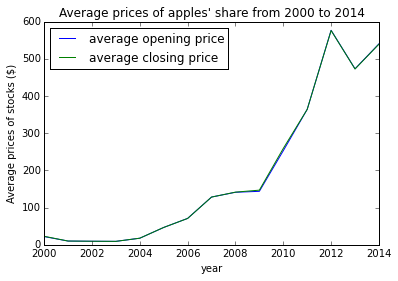

In [18]:
fig,  sp = plt.subplots(figsize = (6,4))
sp.plot(df["year"], df["average_opening_price"], label="average opening price")
sp.plot(df["year"], df["average_closing_price"], label="average closing price")
sp.legend(loc=2); # upper left corner
sp.set_xlabel('year')
sp.set_ylabel('Average prices of stocks ($)')
sp.set_title("Average prices of apples' share from 2000 to 2014");

In [17]:
# up to 2014, which are the top ten days on which the highest single-day increase 
# in Apple's share value were recorded and what are the values. 
highest_singleday_increase = """SELECT date, open, close, (close - open) AS days_increase
                          FROM stockprice2014
                          WHERE (open >= 0.00 and open != "") 
                          ORDER BY days_increase DESC
                          LIMIT 10"""

print(get_query(highest_singleday_increase))

       date    open   close  days_increase
0    3/1/00    0.00   32.58          32.58
1    3/3/00    0.00   32.00          32.00
2    3/6/00    0.00   31.42          31.42
3   4/17/12  578.94  609.70          30.76
4    3/2/00    0.00   30.50          30.50
5   3/13/00    0.00   30.33          30.33
6   8/28/00    0.00   29.03          29.03
7   5/21/12  534.50  561.28          26.78
8  11/19/12  540.71  565.73          25.02
9  12/31/12  510.53  532.17          21.64


In [19]:
#How does the average daily price change in Apple stock differ from year to year
average_dailyprice = """ SELECT year,
                         AVG(close - open) AS avg_daily_change
                         FROM stockprice2014
                         GROUP BY year
                         ORDER BY year"""
print(get_query(average_dailyprice))

    year  avg_daily_change
0   2000          0.688651
1   2001          0.026169
2   2002          0.005913
3   2003          0.008611
4   2004          0.059087
5   2005          0.046151
6   2006         -0.184303
7   2007         -0.114940
8   2008          0.373882
9   2009          3.141128
10  2010          6.124247
11  2011         -0.049762
12  2012         -0.603000
13  2013         -0.471587
14  2014         -0.959000


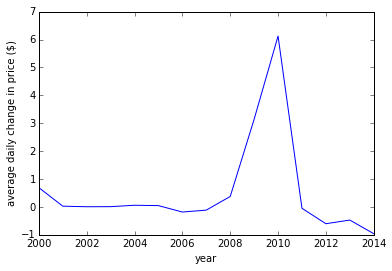

In [20]:
#plot to visualize
df = get_query(average_dailyprice)
plt.plot(df['year'], df['avg_daily_change'])
plt.xlabel('year')
plt.ylabel('average daily change in price ($)')